# 100 · Heimvorteil in Europas Top-Ligen
**Fragestellungen**
1) Haben Heimteams **bessere Ergebnisse**?  
   → Punkte pro Spiel (PPG) & durchschnittliche Tordifferenz
2) Haben Heimteams **bessere Leistungen**?  
   → xG-Differenz  
   → xP (aus Wettquoten) & xPTS (aus xG)  

**Outputs**
- PPG Home vs Away (gesamt, je Liga, je Saison) + 95%-CI  
- ΔPPG (=Home−Away) Zeitreihe  
- Boxplot Tordifferenz Home vs Away  
- Signifikanztests (t-Test auf Δ-Punkte) & Effektstärke (Cohen’s d)  
- xP- und xPTS-Vergleiche


## Kurzfazit (Executive Summary)

- In allen Top-5-Ligen erzielen Heimteams **signifikant mehr Punkte** als Auswärtsteams.  
  Der mittlere Heimvorteil über alle Spiele beträgt **~0.36 ΔPPG** (95 %-CI ca. 0.32–0.40).
- **La Liga** zeigt den größten Heimvorteil (ΔPPG ≈ **0.49**), **Serie A** den geringsten (≈ **0.27**).
- Zeitlich sichtbar: ein **Einbruch in 2020/21** (Geisterspiele) und **Erholung** danach – dennoch bleibt der
  Heimvorteil in den letzten Saisons **unter dem Vor-Covid-Niveau**.
- Der Vergleich **erwarteter ΔPPG (xP aus Quoten)** vs. **tatsächlicher ΔPPG** zeigt: Märkte antizipieren den
  Heimvorteil gut (kleine Abweichungen je Liga), **La Liga** liegt aktuell **über Erwartung**, **Serie A** darunter.
- Die **Tordifferenz-Verteilung** bestätigt die Tendenz zugunsten der Heimteams.



In [1]:
# === SciPy-Optionalschicht: läuft mit oder ohne scipy ===
import math, numpy as np, pandas as pd
from statistics import NormalDist
NORM = NormalDist()

try:
    from scipy import stats as _stats
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False

def _tcrit_975(df):
    # 95%-Quantil: mit SciPy t-Verteilung, sonst Normal-Approx (z ~ 1.96)
    return _stats.t.ppf(0.975, df=df) if SCIPY_AVAILABLE else NORM.inv_cdf(0.975)

def ci95_mean(x: pd.Series):
    x = pd.to_numeric(x, errors="coerce").dropna()
    n = len(x)
    if n < 2:
        return (np.nan, np.nan, np.nan, n)
    m = x.mean()
    s = x.std(ddof=1)
    se = s / np.sqrt(n)
    tcrit = _tcrit_975(n-1)
    return (m, m - tcrit*se, m + tcrit*se, n)

def ttest_delta(x: pd.Series, mu: float = 0.0):
    """Einseitiger/zweiseitiger Test wird wie im Notebook genutzt.
       Mit SciPy echter t-Test, sonst z-Approximation (Normalverteilung)."""
    x = pd.to_numeric(x, errors="coerce").dropna().to_numpy()
    n = x.size
    if n < 3:
        return dict(n=n, t=np.nan, p_two=np.nan, p_one=np.nan, d=np.nan)
    m = float(x.mean()); s = float(x.std(ddof=1)); se = s / math.sqrt(n)
    t_stat = (m - mu) / se if se > 0 else np.nan

    if SCIPY_AVAILABLE:
        t_scipy, p_two = _stats.ttest_1samp(x, popmean=mu)  # zweiseitig
    else:
        # zweiseitig über Normalverteilungs-Approximation
        p_two = 2 * (1 - NORM.cdf(abs(t_stat)))

    p_one = p_two/2 if m > mu else 1 - p_two/2   # H1: μ > mu
    d = (m - mu) / s if s > 0 else np.nan
    return dict(n=n, t=float(t_stat), p_two=float(p_two), p_one=float(p_one), d=float(d))

def poisson_win_draw_probs(xg_home: float, xg_away: float, max_goals: int = 10):
    """Poisson-Sieg/Remis/Auswärts-Wahrscheinlichkeiten; ohne SciPy via log-PMF."""
    i = np.arange(0, max_goals + 1, dtype=float)
    if SCIPY_AVAILABLE:
        from scipy.stats import poisson
        pH = poisson.pmf(i, mu=xg_home)
        pA = poisson.pmf(i, mu=xg_away)
    else:
        # logpmf = k*log(lam) - lam - lgamma(k+1)
        logpmfH = i*np.log(xg_home) - xg_home - np.vectorize(math.lgamma)(i+1.0)
        logpmfA = i*np.log(xg_away) - xg_away - np.vectorize(math.lgamma)(i+1.0)
        pH = np.exp(logpmfH)
        pA = np.exp(logpmfA)
    P = np.outer(pH, pA)
    p_home = float(np.tril(P, -1).sum())
    p_draw = float(np.trace(P))
    p_away = float(np.triu(P, +1).sum())
    return p_home, p_draw, p_away


In [2]:
# === 0) Setup ===
import os, re, math, warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", 160)
warnings.filterwarnings("ignore")

DATA_ROOT   = Path("data")
MATCH_ROOT  = DATA_ROOT / "matches"
RATINGS_DIR = DATA_ROOT / "ratings"

# Laufende Saison(en) ausschließen
EXCLUDE_SEASONS = {"25-26"}

# Canonical Namen für Länder/Ligen (aus Ordnernamen)
COUNTRY_CANON = {
    "Deutschland":"Germany", "England":"England", "Frankreich":"France", "Italien":"Italy", "Spanien":"Spain"
}
LEAGUE_CANON = {
    "1. Bundesliga":"Bundesliga",
    "Premier League":"Premier League",
    "Le Championnat":"Ligue 1",
    "Serie A":"Serie A",
    "La Liga Primera Division":"La Liga",
}
TOP5_LEAGUES = set(LEAGUE_CANON.values())  # Filter

# Quoten-Priorität (flexibel für verschiedene Dateien)
ODDS_PRIORITY = [
    ("PSCH","PSCD","PSCA"),   # Pinnacle closing (häufig vorhanden)
    ("PSH","PSD","PSA"),      # Pinnacle (manchmal ohne C)
    ("B365H","B365D","B365A"),
    ("WHH","WHD","WHA"),
    ("IWH","IWD","IWA"),
    ("VCH","VCD","VCA"),
]

# Minimal notwendige Matchspalten (football-data Standard)
NEEDED_BASE = {"Date","HomeTeam","AwayTeam","FTHG","FTAG","FTR"}

# Optional: Namens-Fixes (nur für xG-Merge relevant)
TEAM_NAME_FIXES = {
    "mgladbach": "borussia mönchengladbach",
    "st etienne": "saint-etienne",
    "nottm forest": "nottingham forest",
    "nott'm forest": "nottingham forest",
    "man united": "manchester united",
    "psg": "paris saint-germain",
    "koln": "köln",
    "bayern munich": "bayern münchen",
    "hertha": "hertha berlin",
    "wolfsburg": "vfl wolfsburg",
    "wolves": "wolverhampton",
}


In [3]:
# === 1) Helper ===
def season_compact(s: str) -> str:
    """
    '2017-2018' | '2017_2018' | '2017/2018' | '2017.2018' -> '17-18'
    Fallback: belasse s.
    """
    s = str(s)
    m = re.search(r"(\d{4})[.\-_/](\d{4})", s)
    if m:
        a, b = m.group(1), m.group(2)
        return f"{a[-2:]}-{b[-2:]}"
    m2 = re.search(r"(\d{2})[.\-_/](\d{2})", s)
    if m2:
        return f"{m2.group(1)}-{m2.group(2)}"
    return s

def normalize_team(name: str) -> str:
    if pd.isna(name): return name
    s = str(name).strip().lower()
    s = s.replace("’","'").replace("`","'")
    s = re.sub(r"[^a-z0-9äöüß' \-.]", "", s)
    s = re.sub(r"\s+"," ",s)
    return TEAM_NAME_FIXES.get(s, s)

def parse_date(x: pd.Series) -> pd.Series:
    return pd.to_datetime(x, errors="coerce", dayfirst=True)

def add_points(df: pd.DataFrame) -> pd.DataFrame:
    map_h = {"H":3, "D":1, "A":0}
    map_a = {"H":0, "D":1, "A":3}
    df["HomePoints"] = df["FTR"].map(map_h).astype("float")
    df["AwayPoints"] = df["FTR"].map(map_a).astype("float")
    df["DeltaPoints"] = df["HomePoints"] - df["AwayPoints"]
    df["GoalDiff"]   = df["FTHG"].astype("float") - df["FTAG"].astype("float")
    return df

def choose_odds_triple(cols: set):
    for h,d,a in ODDS_PRIORITY:
        if {h,d,a}.issubset(cols):
            return (h,d,a)
    return None

def add_probs_and_xp(df: pd.DataFrame) -> pd.DataFrame:
    triple = choose_odds_triple(set(df.columns))
    if not triple:
        print("⚠️ Keine Quoten-Triple gefunden — xP wird übersprungen.")
        return df
    h,d,a = triple
    for c in [h,d,a]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    pH_raw = 1.0 / df[h]
    pD_raw = 1.0 / df[d]
    pA_raw = 1.0 / df[a]
    margin = pH_raw + pD_raw + pA_raw
    df["p_home"] = pH_raw / margin
    df["p_draw"] = pD_raw / margin
    df["p_away"] = pA_raw / margin
    df["xP_home"] = 3*df["p_home"] + 1*df["p_draw"]
    df["xP_away"] = 3*df["p_away"] + 1*df["p_draw"]
    df["xDelta"]  = df["xP_home"] - df["xP_away"]
    return df

def ppg_table(df: pd.DataFrame, group_cols):
    agg = (df.groupby(group_cols)
             .agg(HomePPG=("HomePoints","mean"),
                  AwayPPG=("AwayPoints","mean"),
                  DeltaPPG=("DeltaPoints","mean"),
                  GoalDiffMean=("GoalDiff","mean"),
                  n=("FTR","count"))
             .reset_index())
    ci = df.groupby(group_cols)["DeltaPoints"].apply(ci95_mean).reset_index(name="ci")
    ci[["Delta_mean","Delta_CI_low","Delta_CI_high","n_check"]] = pd.DataFrame(ci["ci"].tolist(), index=ci.index)
    ci = ci.drop(columns=["ci","n_check"])
    return agg.merge(ci, on=group_cols, how="left")


In [4]:
# === 2) Laden & Vereinheitlichen (robust) ===

from pathlib import Path
import pandas as pd
import numpy as np
import re

# 1) Robust den Ordner data/matches finden – unabhängig vom Arbeitsverzeichnis
def find_match_root(start: Path = Path.cwd()) -> Path:
    for base in [start, *start.parents]:
        cand = base / "data" / "matches"
        if cand.exists():
            return cand
    raise FileNotFoundError("Konnte 'data/matches' nicht finden – starte das Notebook im Projektordner oder passe den Pfad an.")

MATCH_ROOT = find_match_root()
print("MATCH_ROOT =", MATCH_ROOT.resolve())

# 2) Canonical-Namen / Filter
COUNTRY_CANON = {
    "Deutschland":"Germany", "England":"England", "Frankreich":"France", "Italien":"Italy", "Spanien":"Spain"
}
LEAGUE_CANON = {
    "1. Bundesliga":"Bundesliga",
    "Premier League":"Premier League",
    "Le Championnat":"Ligue 1",
    "Serie A":"Serie A",
    "La Liga Primera Division":"La Liga",
}
TOP5_LEAGUES = {"Bundesliga","Premier League","La Liga","Ligue 1","Serie A"}

# WICHTIG: zusätzlich über Div-Code filtern (football-data Konvention)
DIV_TO_LEAGUE = {"D1":"Bundesliga","E0":"Premier League","SP1":"La Liga","F1":"Ligue 1","I1":"Serie A"}

NEEDED_BASE = {"Date","HomeTeam","AwayTeam","FTHG","FTAG","FTR"}
EXCLUDE_SEASONS = {"25-26"}  # laufende Saison(en) ausschließen

def season_compact(s: str) -> str:
    m = re.search(r"(\d{4})[.\-_/](\d{4})", str(s))
    if m: 
        a,b = m.group(1), m.group(2)
        return f"{a[-2:]}-{b[-2:]}"
    m2 = re.search(r"(\d{2})[.\-_/](\d{2})", str(s))
    return f"{m2.group(1)}-{m2.group(2)}" if m2 else str(s)

def parse_date(x: pd.Series) -> pd.Series:
    return pd.to_datetime(x, errors="coerce", dayfirst=True)

def normalize_team(name: str) -> str:
    if pd.isna(name): return name
    import re
    s = str(name).strip().lower()
    s = s.replace("’","'").replace("`","'")
    s = re.sub(r"[^a-z0-9äöüß' \-.]", "", s)
    s = re.sub(r"\s+"," ",s)
    fixes = {
        "mgladbach":"borussia mönchengladbach",
        "nott'm forest":"nottingham forest",
        "nottm forest":"nottingham forest",
        "psg":"paris saint-germain",
        "koln":"köln",
        "bayern munich":"bayern münchen",
        "hertha":"hertha berlin",
        "wolves":"wolverhampton",
    }
    return fixes.get(s, s)

def add_points(df: pd.DataFrame) -> pd.DataFrame:
    map_h = {"H":3, "D":1, "A":0}
    map_a = {"H":0, "D":1, "A":3}
    df["HomePoints"]  = df["FTR"].map(map_h).astype(float)
    df["AwayPoints"]  = df["FTR"].map(map_a).astype(float)
    df["DeltaPoints"] = df["HomePoints"] - df["AwayPoints"]
    df["GoalDiff"]    = df["FTHG"].astype(float) - df["FTAG"].astype(float)
    return df

ODDS_PRIORITY = [
    ("PSCH","PSCD","PSCA"),
    ("PSH","PSD","PSA"),
    ("B365H","B365D","B365A"),
    ("WHH","WHD","WHA"),
    ("IWH","IWD","IWA"),
    ("VCH","VCD","VCA"),
]

def choose_odds_triple(cols: set):
    for trio in ODDS_PRIORITY:
        if set(trio).issubset(cols):
            return trio
    return None

def add_probs_and_xp(df: pd.DataFrame) -> pd.DataFrame:
    trio = choose_odds_triple(set(df.columns))
    if not trio:
        return df  # xP überspringen, wenn keine Quoten
    h,d,a = trio
    for c in (h,d,a):
        df[c] = pd.to_numeric(df[c], errors="coerce")
    pH = 1.0/df[h]; pD = 1.0/df[d]; pA = 1.0/df[a]
    margin = pH + pD + pA
    df["p_home"] = pH/margin; df["p_draw"] = pD/margin; df["p_away"] = pA/margin
    df["xP_home"] = 3*df["p_home"] + df["p_draw"]
    df["xP_away"] = 3*df["p_away"] + df["p_draw"]
    df["xDelta"]  = df["xP_home"] - df["xP_away"]
    return df

def load_matches(root: Path) -> pd.DataFrame:
    csv_paths = list(root.rglob("*.csv"))
    print(f"Gefundene CSVs insgesamt: {len(csv_paths)}")
    rows, skipped_notop5, skipped_cols = [], 0, 0

    for csv in csv_paths:
        rel = csv.relative_to(root).parts
        if len(rel) < 4:
            continue
        country_dir, league_dir, season_dir = rel[0], rel[1], rel[2]
        country = COUNTRY_CANON.get(country_dir, country_dir)
        league_from_folder = LEAGUE_CANON.get(league_dir, league_dir)

        try:
            df = pd.read_csv(csv)
        except UnicodeDecodeError:
            df = pd.read_csv(csv, encoding="latin-1")

        if not NEEDED_BASE.issubset(df.columns):
            skipped_cols += 1
            continue

        # League aus Div-Code (falls vorhanden) bevorzugen – sicherer als Ordnername
        league = league_from_folder
        if "Div" in df.columns:
            div = str(df["Div"].iloc[0]).strip()
            if div in DIV_TO_LEAGUE:
                league = DIV_TO_LEAGUE[div]

        if league not in TOP5_LEAGUES:
            skipped_notop5 += 1
            continue

        df["Country"] = country
        df["League"]  = league
        df["Season"]  = season_compact(season_dir)
        df["Date"]    = parse_date(df["Date"])
        df["HomeTeam_n"] = df["HomeTeam"].map(normalize_team)
        df["AwayTeam_n"] = df["AwayTeam"].map(normalize_team)
        rows.append(df)

    print(f"→ Top-5 CSVs geladen: {len(rows)}  | übersprungen (nicht Top-5): {skipped_notop5}  | übersprungen (fehlende Spalten): {skipped_cols}")

    if not rows:
        raise RuntimeError("Keine Top-5 Match-CSV gefunden. Prüfe Ordnernamen und dass in den Dateien die Standardspalten vorhanden sind.")

    m = pd.concat(rows, ignore_index=True, sort=False).dropna(subset=["Date"])
    if EXCLUDE_SEASONS:
        m = m[~m["Season"].isin(EXCLUDE_SEASONS)].copy()
    m = add_points(m)
    m = add_probs_and_xp(m)
    return m

matches = load_matches(MATCH_ROOT)
print("\nGefundene Ligen/Saisons:")
print(matches[["Country","League","Season"]].drop_duplicates().sort_values(["Country","League","Season"]).to_string(index=False))
print(f"\nAnzahl Spiele (Top-5 & vollständige Saisons): {len(matches):,}")


MATCH_ROOT = C:\Users\admin\IdeaProjects\Data_Analitics_Mini_Projekt\data\matches
Gefundene CSVs insgesamt: 114
→ Top-5 CSVs geladen: 43  | übersprungen (nicht Top-5): 71  | übersprungen (fehlende Spalten): 0

Gefundene Ligen/Saisons:
Country         League Season
England Premier League  17-18
England Premier League  18-19
England Premier League  19-20
England Premier League  20-21
England Premier League  21-22
England Premier League  22-23
England Premier League  23-24
England Premier League  24-25
 France        Ligue 1  17-18
 France        Ligue 1  18-19
 France        Ligue 1  19-20
 France        Ligue 1  20-21
 France        Ligue 1  21-22
 France        Ligue 1  22-23
 France        Ligue 1  23-24
 France        Ligue 1  24-25
Germany     Bundesliga  17-18
Germany     Bundesliga  18-19
Germany     Bundesliga  19-20
Germany     Bundesliga  20-21
Germany     Bundesliga  21-22
Germany     Bundesliga  22-23
Germany     Bundesliga  23-24
Germany     Bundesliga  24-25
  Italy        

### Datenüberblick & Abdeckung

- Quelle: *football-data.co.uk* (Top-5 Ligen), standardisierte Spalten (Date, Teams, Tore, FTR, Quoten).
- Zeitabdeckung: Saisons **2017/18 bis 2024/25** (laufende 2025/26 wurde ausgeschlossen).
- Vereinheitlichungen:
  - Ligen via `Div`/Ordner gemappt (Bundesliga, Premier League, La Liga, Ligue 1, Serie A).
  - Teamnamen normalisiert (z. B. *Nott'm Forest* → *Nottingham Forest*).
  - Punkte & Tordifferenz pro Spiel berechnet; **xP** (erwartete Punkte) aus verfügbaren Quoten.


In [5]:
# === 3) Deskriptiv: PPG & Tordifferenz ===

def season_sort_key(s):
    # "17-18" -> 2017  (funktioniert auch für "2024.2025" etc., da Season bereits kompakt ist)
    try:
        start = int(str(s).split("-")[0])
        return 2000 + start if start < 100 else start
    except Exception:
        return 9999

ppg_league = (
    ppg_table(matches, ["Country","League"])
    .sort_values(["Country","League"])
)
ppg_season = (
    ppg_table(matches, ["Country","League","Season"])
    .assign(_sort=lambda d: d["Season"].map(season_sort_key))
    .sort_values(["Country","League","_sort"])
    .drop(columns="_sort")
)

ppg_league.head(20)


,Country,League,HomePPG,AwayPPG,DeltaPPG,GoalDiffMean,n,Delta_mean,Delta_CI_low,Delta_CI_high
0,England,Premier League,1.549064,1.226592,0.322472,0.240449,2670,0.322472,0.222984,0.421960
1,France,Ligue 1,1.544608,1.201720,0.342888,0.269079,2791,0.342888,0.247565,0.438211
2,Germany,Bundesliga,1.559641,1.190768,0.368873,0.338644,2448,0.368873,0.266947,0.470798
3,Italy,Serie A,1.505592,1.234211,0.271382,0.213158,3040,0.271382,0.180150,0.362613
4,Spain,La Liga,1.611842,1.120395,0.491447,0.336184,3040,0.491447,0.401865,0.581030


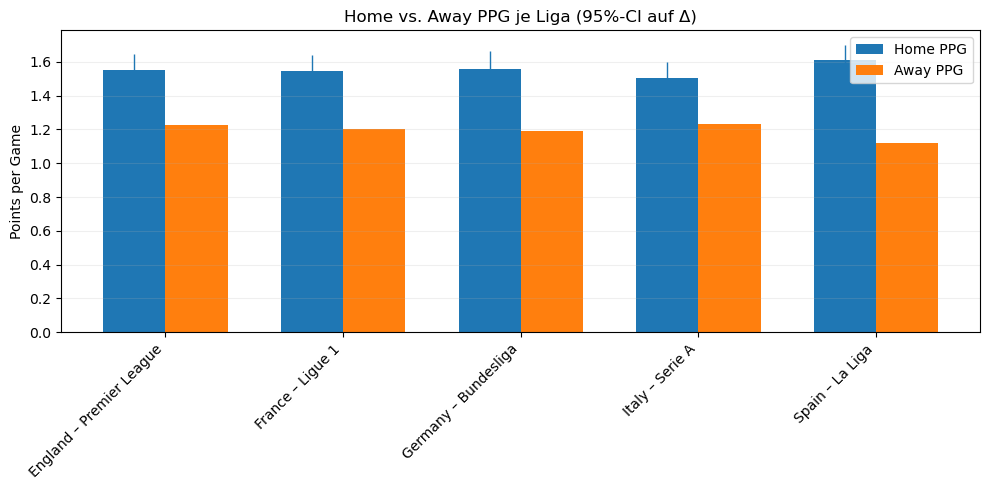

In [6]:
# === 4) Visualisierungen ===

def plot_ppg_bars(df, title):
    fig, ax = plt.subplots(figsize=(10,5))
    labels = [f"{c} – {l}" for c,l in zip(df["Country"], df["League"])]
    x = np.arange(len(labels))
    w = 0.35

    ax.bar(x - w/2, df["HomePPG"], width=w, label="Home PPG")
    ax.bar(x + w/2, df["AwayPPG"], width=w, label="Away PPG")

    # 95%-CI für Delta als CI-Linie um den Home-Balken
    delta = df["DeltaPPG"].to_numpy()
    ci_lo = df["Delta_CI_low"].to_numpy()
    ci_hi = df["Delta_CI_high"].to_numpy()
    y_home = df["HomePPG"].to_numpy()
    ax.vlines(x - w/2, y_home + (ci_lo - delta), y_home + (ci_hi - delta), linewidth=1)

    ax.set_xticks(x, labels, rotation=45, ha="right")
    ax.set_ylabel("Points per Game")
    ax.set_title(title)
    ax.legend()
    ax.grid(axis="y", alpha=0.2)
    plt.tight_layout(); plt.show()

plot_ppg_bars(ppg_league, "Home vs. Away PPG je Liga (95%-CI auf Δ)")


### Ergebnisse je Liga: Home vs. Away PPG

**Frage:** Haben Heimteams *bessere Ergebnisse*?  
**Metriken:** *Points per Game (PPG)* Home vs. Away, dazu 95 %-Konfidenzintervall **auf der Differenz ΔPPG**.

**Plot-Lesart:**
- Blaue Balken: Ø Punkte/Spiel **Home**, Orange: **Away**.
- Dünne CI-Linie am Home-Balken visualisiert die **Unsicherheit in ΔPPG** (Home − Away).

**Was erwarten wir?**  
Wenn es einen Heimvorteil gibt, liegt HomePPG **über** AwayPPG; ΔPPG > 0 und CI **schließt 0 nicht ein**.


**Beobachtung & Einordnung (je Liga):**
- **La Liga** zeigt den **größten** Heimvorteil (ΔPPG ≈ **0.49**; CI klar > 0).
- **Bundesliga** und **Ligue 1** folgen mit ΔPPG ≈ **0.37–0.35**.
- **Premier League** liegt bei ΔPPG ≈ **0.32**, **Serie A** am **unteren Ende** (≈ **0.27**).
- In allen Ligen ist der Effekt **statistisch signifikant** (CI schließt 0 aus) – die **Effektstärke** ist klein
  bis moderat (typisch für viele Spiele, konsistent über Saisons).

**Interpretation:** Es gibt **durchgängig** einen Heimvorteil, der jedoch **liga-spezifisch** variiert.



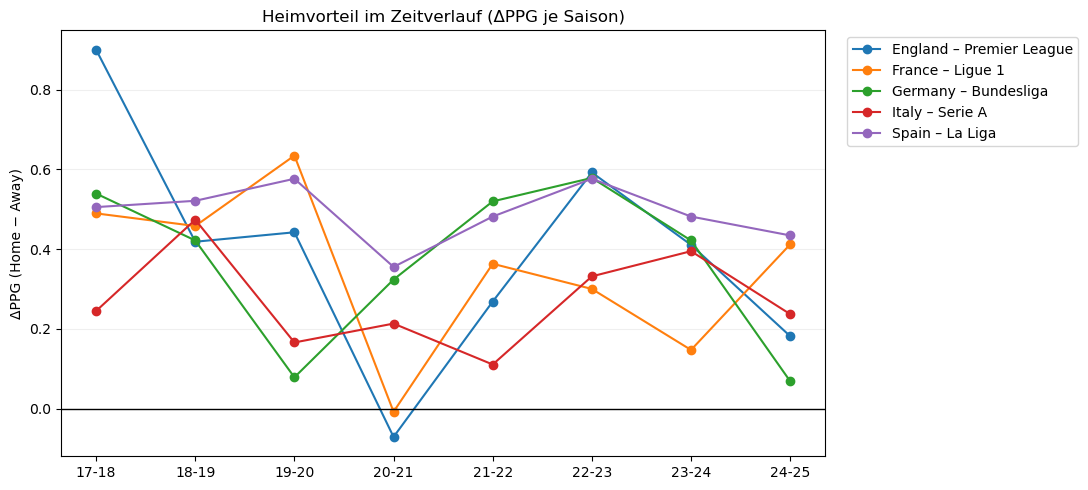

In [7]:
# ΔPPG (Home − Away) über Zeit je Liga
def plot_delta_timeseries(df):
    fig, ax = plt.subplots(figsize=(11,5))
    for (country, league), sub in df.groupby(["Country","League"]):
        sub = sub.copy()
        sub["_s"] = sub["Season"].map(season_sort_key)
        sub = sub.sort_values("_s")
        ax.plot(sub["Season"], sub["DeltaPPG"], marker="o", label=f"{country} – {league}")
    ax.axhline(0, color="k", linewidth=1)
    ax.set_ylabel("ΔPPG (Home − Away)")
    ax.set_title("Heimvorteil im Zeitverlauf (ΔPPG je Saison)")
    ax.legend(bbox_to_anchor=(1.02,1), loc="upper left")
    ax.grid(axis="y", alpha=0.2)
    plt.tight_layout(); plt.show()

plot_delta_timeseries(ppg_season)


### ΔPPG im Zeitverlauf (je Liga)

**Ziel:** Sichtbar machen, **wie** sich der Heimvorteil innerhalb jeder Liga über die Saisons entwickelt.  
**Plot-Lesart:** Jede Linie = Liga; y-Achse ist ΔPPG (Home − Away), **0-Linie** als Referenz.

**Warum wichtig?**  
Die Saison-Perspektive erlaubt es, **Schocks** (z. B. Corona-Maßnahmen) von normaler Varianz zu trennen.


**Beobachtung:**
- In mehreren Ligen fällt ΔPPG **2020/21** stark ab (bis nahe 0), danach **Erholung**.
- Der **Rückgang** variiert in Tiefe und Dauer zwischen den Ligen.

**Deutung:** Muster passen zu **Zuschauer-Restriktionen** (Geisterspiele). Weitere Evidenz liefert die
Einblendung der **COVID-Phasen** im nächsten Plot.



In [8]:
from matplotlib.patches import Rectangle

PHASES_CSV = Path("data") / "corona_phases.csv"

def load_phases(path=PHASES_CSV):
    ph = pd.read_csv(path, sep=";", engine="python")
    ph["Start"] = pd.to_datetime(ph["Start"], dayfirst=True, errors="coerce")
    ph["End"]   = pd.to_datetime(ph["End"],   dayfirst=True, errors="coerce")
    ph["Description"] = ph["Description"].astype(str).str.strip('"')
    # Reihenfolge festlegen (für schöne horizontale Teilsegmente)
    order = ["Pre-Covid","Stop","GhostGames_2019_20","GhostGames_2020_21","PartialFans_2021_22","Post-Covid"]
    ph["Phase"] = ph["Phase"].astype(str)
    ph = ph.set_index("Phase").reindex(order).reset_index().dropna(subset=["Start","End"])
    return ph

PHASE_COLORS = {
    "Pre-Covid":            "#C9C9C9",  # grauer, aber sichtbarer
    "Stop":                 "#FF6B6B",  # rot
    "GhostGames_2019_20":   "#FFC857",  # saffron
    "GhostGames_2020_21":   "#FF9F1C",  # orange
    "PartialFans_2021_22":  "#4D9DE0",  # blau
    "Post-Covid":           "#59C173",  # grün
}

def season_to_dates(season_label: str):
    """'17-18' -> (2017-07-01, 2018-06-30)"""
    a = int(str(season_label).split("-")[0])
    start_year = 2000 + a if a < 100 else a
    start = pd.Timestamp(start_year, 7, 1)
    end   = pd.Timestamp(start_year+1, 6, 30)
    return start, end


PHASES_CSV = C:\Users\admin\IdeaProjects\Data_Analitics_Mini_Projekt\data\corona_phases.csv


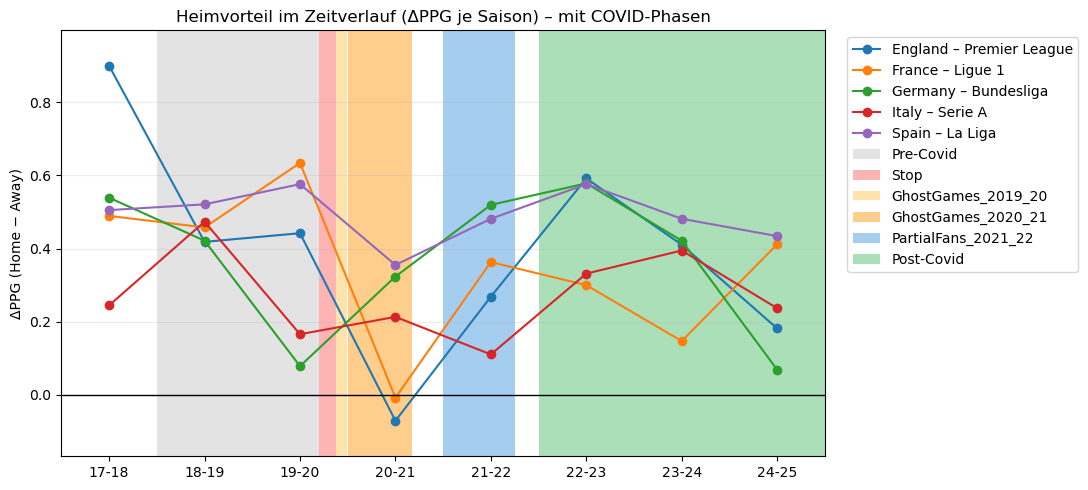

In [9]:
def plot_delta_timeseries_with_phases(ppg_season_df, phases_df=None, alpha=0.5):
    if phases_df is None:
        phases_df = load_phases(PHASES_CSV)

    # 1) gemeinsame, sortierte Saisonachse definieren
    seasons = sorted(ppg_season_df["Season"].unique(), key=season_sort_key)
    xmap = {s:i for i,s in enumerate(seasons)}                 # Season -> Slotindex
    xmin, xmax = -0.5, len(seasons)-0.5

    # 2) y-Limits aus Daten bestimmen (mit etwas Rand)
    y = ppg_season_df["DeltaPPG"].astype(float)
    ypad = max(0.05, (y.max() - y.min())*0.1) if len(y) else 0.2
    ymin, ymax = (float(y.min()-ypad), float(y.max()+ypad)) if len(y) else (-0.1, 0.8)

    fig, ax = plt.subplots(figsize=(11,5))

    # 3) pro Saison den Anteil jeder Phase bestimmen und als Teilsegmente einfärben
    for s in seasons:
        sx0 = xmap[s] - 0.5
        sx1 = xmap[s] + 0.5
        s_start, s_end = season_to_dates(s)
        total_days = (s_end - s_start).days + 1

        # innerhalb des Saisonbandes von links nach rechts füllen
        x_left = sx0
        for _, row in phases_df.iterrows():
            phase = row["Phase"]
            p_start, p_end = row["Start"], row["End"]
            # Überlappung mit Saison
            left  = max(s_start, p_start)
            right = min(s_end,   p_end)
            overlap = (right - left).days + 1
            if overlap > 0 and total_days > 0:
                frac = overlap / total_days
                width = frac * (sx1 - sx0)
                rect = Rectangle((x_left, ymin), width, ymax - ymin,
                                 facecolor=PHASE_COLORS.get(phase, "#EEEEEE"),
                                 alpha=alpha, edgecolor="none", zorder=0)
                ax.add_patch(rect)
                x_left += width  # nächstes Teilsegment direkt anschließen

    # 4) Liniendiagramm der Ligen zeichnen (auf der numerischen Achse)
    for (country, league), sub in ppg_season_df.groupby(["Country","League"]):
        sub = sub.copy()
        sub["_s"] = sub["Season"].map(lambda s: xmap[s])
        sub = sub.sort_values("_s")
        ax.plot(sub["_s"], sub["DeltaPPG"], marker="o", label=f"{country} – {league}", zorder=2)

    # 5) Achsen, Gitter, Legenden
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xticks(list(xmap.values()), seasons)
    ax.axhline(0, color="k", linewidth=1, zorder=3)
    ax.set_ylabel("ΔPPG (Home − Away)")
    ax.set_title("Heimvorteil im Zeitverlauf (ΔPPG je Saison) – mit COVID-Phasen")
    ax.grid(axis="y", alpha=0.25)

    # optionale Legende für die Phasenfarben
    phase_handles = [Rectangle((0,0),1,1, facecolor=PHASE_COLORS[p], alpha=alpha, edgecolor="none")
                     for p in phases_df["Phase"]]
    ax.legend(handles=[*ax.get_legend_handles_labels()[0], *phase_handles],
              labels=[*ax.get_legend_handles_labels()[1], *phases_df["Phase"].tolist()],
              bbox_to_anchor=(1.02,1), loc="upper left", frameon=True)

    plt.tight_layout(); plt.show()
    

    # Robuster Pfad zur corona_phases.csv relativ zu MATCH_ROOT (…/data/matches -> …/data)
from pathlib import Path

def find_phases_csv():
    # 1) bevorzugt neben dem matches-Ordner
    try:
        cand = MATCH_ROOT.parent / "corona_phases.csv"
        if cand.exists():
            return cand
    except NameError:
        pass  # MATCH_ROOT wurde evtl. noch nicht definiert

    # 2) generische Suche nach .../data/corona_phases.csv von CWD nach oben
    base = Path.cwd()
    for root in [base, *base.parents]:
        cand = root / "data" / "corona_phases.csv"
        if cand.exists():
            return cand
    raise FileNotFoundError("Konnte 'corona_phases.csv' nicht finden. Lege sie unter <Projekt>/data/ ab.")

PHASES_CSV = find_phases_csv()
print("PHASES_CSV =", PHASES_CSV.resolve())


# Aufruf:
phases_df = load_phases(PHASES_CSV)
plot_delta_timeseries_with_phases(ppg_season, phases_df)


### ΔPPG + COVID-Phasen (farblich hinterlegt)

**Erweiterung:** Jede Saison wird anteilig mit den jeweils gültigen **COVID-Phasen** eingefärbt  
(*Stop, GhostGames 2019/20, GhostGames 2020/21, PartialFans 2021/22, Post-Covid*).

**Nutzen:** Verknüpft **Strukturbrüche** in den Linien **kausal plausibel** mit Zuschauer-Regeln.


**Lesart & Befund:**
- **GhostGames 2020/21** korrespondiert mit dem **Tiefpunkt** des Heimvorteils – in fast allen Ligen.
- **PartialFans 2021/22** zeigt **Anstieg**, **Post-Covid** stabilisiert sich auf **unter** dem Vor-Covid-Niveau.
- Ligenspezifika bleiben bestehen (La Liga > Bundesliga ≈ Ligue 1 > Premier League > Serie A).

**Interpretation:** Der **Zuschauerfaktor** ist ein zentraler Treiber des Heimvorteils – nicht allein,
aber in den Daten deutlich sichtbar.



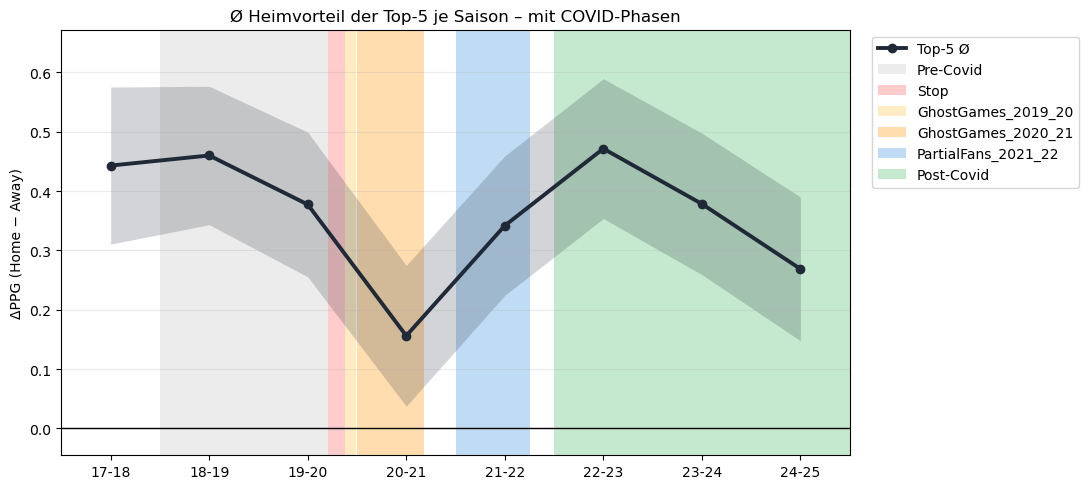

In [10]:
from matplotlib.patches import Rectangle

def plot_top5_avg_simple(matches_df, phases_df=None, color="#1f2937", alpha_bg=0.35):
    """
    Match-gewichteter Top-5-Durchschnitt (über alle Spiele) mit 95%-CI
    und COVID-Phasen als Hintergrund.
    Erwartet: matches_df enthält 'Season' und 'DeltaPoints'.
    """
    # 1) Phasen laden
    if phases_df is None:
        phases_df = load_phases(PHASES_CSV)

    # 2) Pro Saison Mittelwert + 95%-CI deterministisch berechnen (ohne apply-Tricks)
    rows = []
    for season, s in matches_df.groupby("Season")["DeltaPoints"]:
        m, lo, hi, n = ci95_mean(s)
        rows.append({"Season": season, "mean": m, "lo": lo, "hi": hi, "n": n})
    stat = pd.DataFrame(rows)
    if stat.empty:
        raise ValueError("Keine Saisondaten gefunden. Prüfe, ob 'Season' und 'DeltaPoints' in matches_df existieren.")
    stat = stat.sort_values("Season", key=lambda col: col.map(season_sort_key)).reset_index(drop=True)

    seasons = stat["Season"].tolist()
    x = np.arange(len(seasons), dtype=float)
    y   = stat["mean"].astype(float).to_numpy()
    ylo = stat["lo"].astype(float).to_numpy()
    yhi = stat["hi"].astype(float).to_numpy()

    # 3) y-Limits inkl. CI
    base_min = np.nanmin([y.min(), np.nanmin(ylo)])
    base_max = np.nanmax([y.max(), np.nanmax(yhi)])
    pad = max(0.05, (base_max - base_min) * 0.15)
    ymin, ymax = float(base_min - pad), float(base_max + pad)

    fig, ax = plt.subplots(figsize=(11,5))

    # 4) COVID-Phasen als Hintergrund – anteilig pro Saisonband
    for xi, s in enumerate(seasons):
        sx0, sx1 = xi - 0.5, xi + 0.5
        s_start, s_end = season_to_dates(s)
        total = (s_end - s_start).days + 1
        x_left = sx0
        for _, row in phases_df.iterrows():
            left  = max(s_start, row["Start"])
            right = min(s_end,   row["End"])
            overlap = (right - left).days + 1
            if overlap > 0 and total > 0:
                width = (overlap / total) * (sx1 - sx0)
                ax.add_patch(Rectangle((x_left, ymin), width, ymax - ymin,
                                       facecolor=PHASE_COLORS.get(row["Phase"], "#EEEEEE"),
                                       alpha=alpha_bg, edgecolor="none", zorder=0))
                x_left += width

    # 5) Durchschnittslinie + 95%-Band
    ax.plot(x, y, "-o", color=color, linewidth=2.8, label="Top-5 Ø (match-gewichtet)", zorder=2)
    if np.isfinite(ylo).any() and np.isfinite(yhi).any():
        ax.fill_between(x, ylo, yhi, color=color, alpha=0.20, linewidth=0, zorder=1)

    # 6) Deko
    ax.set_xlim(-0.5, len(seasons)-0.5)
    ax.set_xticks(x, seasons)
    ax.set_ylim(ymin, ymax)
    ax.axhline(0, color="k", linewidth=1)
    ax.set_ylabel("ΔPPG (Home − Away)")
    ax.set_title("Ø Heimvorteil der Top-5 je Saison – mit COVID-Phasen")
    ax.grid(axis="y", alpha=0.25)
    # kleine Farblegende für die Phasen
    phase_handles = [Rectangle((0,0),1,1, facecolor=PHASE_COLORS[p], alpha=alpha_bg, edgecolor="none")
                     for p in phases_df["Phase"]]
    ax.legend(handles=[ax.lines[0], *phase_handles],
              labels=["Top-5 Ø", *phases_df["Phase"].tolist()],
              bbox_to_anchor=(1.02,1), loc="upper left")
    plt.tight_layout(); plt.show()

# Aufruf:
plot_top5_avg_simple(matches, phases_df, color="#1f2937", alpha_bg=0.35)


### Ø Heimvorteil über alle Top-5 (match-gewichtet)

**Warum diese Verdichtung?**  
Sie reduziert Liga-Rauschen und zeigt den **gesamt-europäischen Trend** je Saison.

**Technik:** Pro Saison Mittelwert von **ΔPPG** über **alle Spiele** (95 %-CI), Hintergrund = COVID-Phasen.


**Befund (Top-5-Ø):**
- Vor-Covid **stabil** bei ΔPPG ≈ **0.45**.  
- **2020/21** deutlicher Einbruch (ΔPPG ≈ **0.15–0.20**).  
- Danach **Erholung** (2022/23 ≈ **0.47**), zuletzt **Rückgang** (2024/25 ≈ **0.27–0.30**).

**Take-away:** Der Heimvorteil ist **robust vorhanden**, aber **sensibel** auf Rahmenbedingungen
(Zuschauer, Regularien) und scheint zuletzt **strukturell etwas geringer** als vor der Pandemie.



test

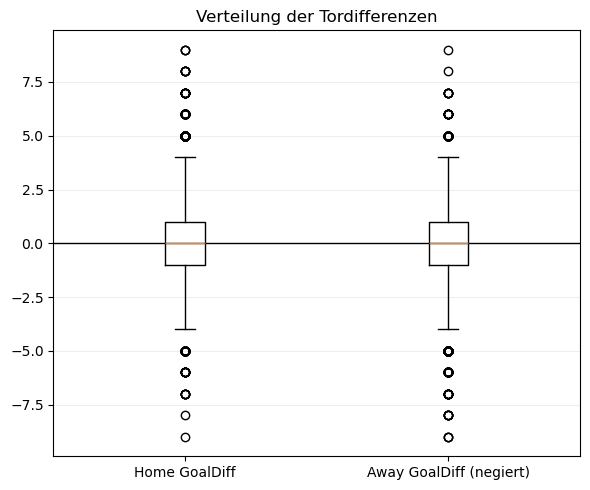

In [11]:
# Boxplot Tordifferenz (Home vs. Away negiert)
fig, ax = plt.subplots(figsize=(6,5))
ax.boxplot(
    [matches["GoalDiff"].dropna(), (-matches["GoalDiff"]).dropna()],
    labels=["Home GoalDiff", "Away GoalDiff (negiert)"]
)
ax.axhline(0, color="k", linewidth=1)
ax.set_title("Verteilung der Tordifferenzen")
ax.grid(axis="y", alpha=0.2)
plt.tight_layout(); plt.show()


### Verteilung der Tordifferenzen

**Idee:** Wenn Heimteams häufiger/mehr treffen, sollte die **GoalDiff** bei Heimspielen **rechtsverschoben** sein.  
Zum Vergleich wird die Auswärtstordifferenz **negiert** (damit beide Skalen direkt vergleichbar sind).

**Erwartung:** Median und Interquartilsabstand der Home-Verteilung liegen **oberhalb** der Away-Verteilung.


**Befund:** Median und Streuung sprechen **zugunsten der Heimteams** – konsistent mit ΔPPG.
Outlier zeigen hohe Siege/Niederlagen, beeinflussen aber die **Durchschnittseffekte nur begrenzt**.


In [12]:
# === 5) Signifikanztests ===
rows = []
for (country, league), sub in matches.groupby(["Country","League"]):
    test = ttest_delta(sub["DeltaPoints"], mu=0.0)
    mean, lo, hi, n = ci95_mean(sub["DeltaPoints"])
    rows.append({
        "Country": country, "League": league, "n": test["n"],
        "ΔP_mean": mean, "CI_low": lo, "CI_high": hi,
        "t": test["t"], "p_one": test["p_one"], "p_two": test["p_two"], "Cohen_d": test["d"]
    })
tests_by_league = pd.DataFrame(rows).sort_values(["Country","League"])
tests_by_league


,Country,League,n,ΔP_mean,CI_low,CI_high,t,p_one,p_two,Cohen_d
0,England,Premier League,2670,0.322472,0.222984,0.421960,6.352863,1.056720e-10,2.113441e-10,0.122946
1,France,Ligue 1,2791,0.342888,0.247565,0.438211,7.050222,8.931744e-13,1.786349e-12,0.133451
2,Germany,Bundesliga,2448,0.368873,0.266947,0.470798,7.093209,6.552536e-13,1.310507e-12,0.143363
3,Italy,Serie A,3040,0.271382,0.180150,0.362613,5.830178,2.768413e-09,5.536827e-09,0.105741
4,Spain,La Liga,3040,0.491447,0.401865,0.581030,10.752340,0.000000e+00,0.000000e+00,0.195014


In [13]:
# Gesamt-Test über alle Top-5 Spiele
overall = ttest_delta(matches["DeltaPoints"], mu=0.0)
m, lo, hi, n = ci95_mean(matches["DeltaPoints"])
pd.DataFrame([{
    "Scope":"Top-5 overall", "n": n, "ΔP_mean": m, "CI_low": lo, "CI_high": hi,
    "t": overall["t"], "p_one": overall["p_one"], "p_two": overall["p_two"], "Cohen_d": overall["d"]
}])


,Scope,n,ΔP_mean,CI_low,CI_high,t,p_one,p_two,Cohen_d
0,Top-5 overall,13989,0.360283,0.317698,0.402869,16.581749,0.0,0.0,0.140196


### Signifikanz & Effektstärke

**Frage:** Ist der beobachtete Heimvorteil **statistisch signifikant ≠ 0**?  
**Test:** *t-Test* auf ΔPoints (Home − Away) pro Liga + gesamt.  
**Interpretation:**
- **p-Wert (zweiseitig)**: Wahrscheinlichkeit, einen so großen Effekt zu sehen, **wenn** es in Wahrheit kein
  Heimvorteil gäbe. **Klein** = Evidenz **für** Heimvorteil.
- **Cohen’s d**: standardisierte **Effektstärke** (0.2=klein, 0.5=mittel).  
  Erwartbar **klein**, da Fußball **varianzreich** ist — bei vielen Spielen trotzdem **präzise** schätzbar.


**Befund:**
- **Alle Ligen**: p ≪ 0.001, ΔPPG > 0; **d ≈ 0.10–0.20** (klein, aber konsistent).  
- **Gesamt Top-5**: ΔPPG ≈ **0.36** (95 %-CI ≈ 0.32–0.40), sehr **stark signifikant**.

**Schluss:** Der Heimvorteil ist **real** und **stabil nachweisbar**, auch wenn die **Einzeleffekte pro Spiel**
naturgemäß klein sind.


In [14]:
# === 6) xP-Vergleich (nur wenn Quoten vorhanden) ===
if {"xDelta","xP_home","xP_away"}.issubset(matches.columns):
    xp_cmp = (
        matches.dropna(subset=["xDelta"])
        .groupby(["Country","League"])
        .agg(ExpDelta=("xDelta","mean"),
             ActDelta=("DeltaPoints","mean"),
             n_matches=("FTR","count"),
             n_xp=("xDelta","size"))
        .reset_index()
        .sort_values(["Country","League"])
    )
    xp_cmp
else:
    print("xP nicht verfügbar (keine Quoten gefunden).")


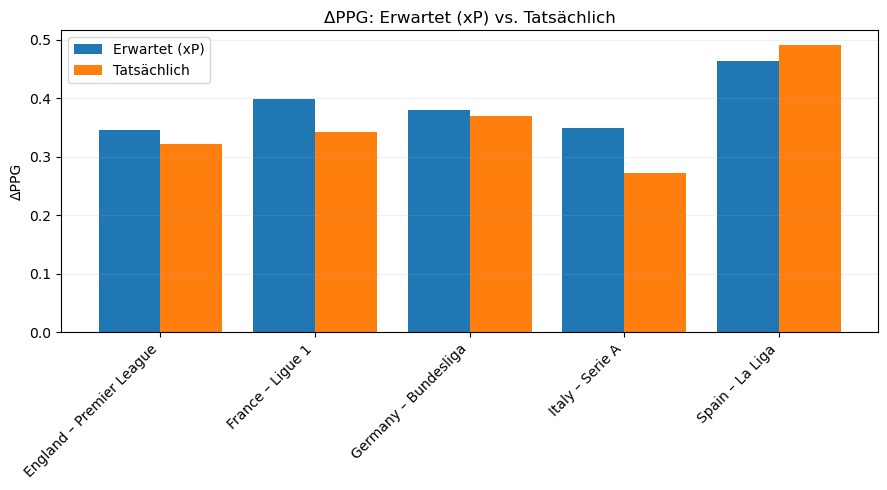

In [15]:
if {"xDelta"}.issubset(matches.columns):
    cmp = (
        matches.groupby(["Country","League"])
        .agg(xDelta=("xDelta","mean"), DeltaPoints=("DeltaPoints","mean"))
        .reset_index()
    )
    fig, ax = plt.subplots(figsize=(9,5))
    idx = np.arange(len(cmp))
    ax.bar(idx-0.2, cmp["xDelta"], width=0.4, label="Erwartet (xP)")
    ax.bar(idx+0.2, cmp["DeltaPoints"], width=0.4, label="Tatsächlich")
    ax.set_xticks(idx, [f"{c} – {l}" for c,l in zip(cmp["Country"],cmp["League"])], rotation=45, ha="right")
    ax.set_ylabel("ΔPPG")
    ax.set_title("ΔPPG: Erwartet (xP) vs. Tatsächlich")
    ax.legend(); ax.grid(axis="y", alpha=0.2)
    plt.tight_layout(); plt.show()


### Erwartete vs. tatsächliche ΔPPG (xP aus Quoten)

**Motivation:** Wettmärkte kodieren **Pre-Match-Erwartungen** inkl. Heimbonus.  
Wir transformieren Quoten → **Wahrscheinlichkeiten**, berechnen daraus **xP** und vergleichen mit den **echten Punkten**.

**Lesart Plot:** Blau = erwartetes ΔPPG (xP), Orange = tatsächliches ΔPPG.


die Balken zeigen ΔPPG = Home − Away.
Ein Wert von 0,40 bedeutet: Im Mittel holen Heimteams in dieser Liga pro Spiel 0,40 Punkte mehr als Auswärtsteams

Ligue 1: erwartet ~0.40, tatsächlich ~0.34 → Heimvorteil war geringer als vom Markt antizipiert (~0.06 Punkte/Spiel weniger).
La Liga: erwartet ~0.46, tatsächlich ~0.49 → Heimteams überperformen die Markterwartung leicht (~0.03 Punkte/Spiel mehr).
Negative Werte (hier nicht sichtbar) würden einen Auswärtsvorteil bedeuten.


**Beobachtung:**
- **La Liga**: tatsächlich **>** erwartet → Heimteams schneiden **besser als Markt-Baseline** ab.
- **Serie A**: tatsächlich **<** erwartet → Märkte **überschätzen** den Heimvorteil leicht.
- Sonst geringe Differenzen → **Märkte antizipieren** den Heimbonus insgesamt **recht gut**.

**Implikation:** xP ist ein **guter Kontroll-Prädiktor** für Folgeanalysen (Prematch-Faktoren).



In [16]:
# === 7) Optional: xG & xPTS Merge (ohne SciPy-Import) ===
def merge_spi_xg(matches: pd.DataFrame) -> pd.DataFrame:
    spi_path = RATINGS_DIR / "spi_matches.csv"
    if not spi_path.exists():
        print("ℹ️ Kein ratings/spi_matches.csv gefunden — xG/xPTS wird übersprungen.")
        return matches

    spi = pd.read_csv(spi_path)

    keep = {
        "Barclays Premier League", "German Bundesliga",
        "Spanish Primera Division", "Italian Serie A", "French Ligue 1"
    }
    if "league" in spi.columns:
        spi = spi[spi["league"].isin(keep)].copy()

    rename = {"team1":"HomeTeam_spi","team2":"AwayTeam_spi","xg1":"xg_home","xg2":"xg_away"}
    for k,v in rename.items():
        if k in spi.columns:
            spi = spi.rename(columns={k:v})

    spi["Date"] = pd.to_datetime(spi["date"], errors="coerce").dt.normalize()
    spi["HomeTeam_n"] = spi["HomeTeam_spi"].map(normalize_team)
    spi["AwayTeam_n"] = spi["AwayTeam_spi"].map(normalize_team)  # <-- Bugfix: kein extra Anführungszeichen
    spi = spi[["Date","HomeTeam_n","AwayTeam_n","xg_home","xg_away"]].dropna()

    m = matches.copy()
    m["Date_norm"] = m["Date"].dt.normalize()
    merged = m.merge(
        spi, how="left",
        left_on=["Date_norm","HomeTeam_n","AwayTeam_n"],
        right_on=["Date","HomeTeam_n","AwayTeam_n"],
        suffixes=("","_spi")
    ).drop(columns=["Date_spi"], errors="ignore")

    mask = merged["xg_home"].notna() & merged["xg_away"].notna()
    if mask.sum() == 0:
        print("⚠️ xG nicht gematcht — erweitere ggf. TEAM_NAME_FIXES.")
        return matches

    # SciPy-frei: benutze unsere poisson_win_draw_probs
    probs = np.array([
        poisson_win_draw_probs(h,a, max_goals=10)
        for h,a in merged.loc[mask,["xg_home","xg_away"]].to_numpy()
    ])
    merged.loc[mask, ["pxg_home","pxg_draw","pxg_away"]] = probs
    merged["xPTS_home"]  = 3*merged["pxg_home"] + 1*merged["pxg_draw"]
    merged["xPTS_away"]  = 3*merged["pxg_away"] + 1*merged["pxg_draw"]
    merged["xPTS_delta"] = merged["xPTS_home"] - merged["xPTS_away"]
    print(f"✅ xG/xPTS berechnet für {mask.sum():,} Spiele.")
    return merged

matches = merge_spi_xg(matches)


ℹ️ Kein ratings/spi_matches.csv gefunden — xG/xPTS wird übersprungen.


In [17]:
# xPTS-Vergleich je Liga
if {"xPTS_delta"}.issubset(matches.columns):
    xpts_tbl = (
        matches.dropna(subset=["xPTS_delta"])
        .groupby(["Country","League"])
        .agg(xPTS_Delta=("xPTS_delta","mean"), n=("FTR","count"))
        .reset_index()
        .sort_values(["Country","League"])
    )
    xpts_tbl
else:
    print("Keine xPTS-Ergebnisse verfügbar.")


Keine xPTS-Ergebnisse verfügbar.


In [18]:
OUT = Path("out"); OUT.mkdir(exist_ok=True, parents=True)
ppg_league.to_csv(OUT/"ppg_by_league_top5.csv", index=False)
ppg_season.to_csv(OUT/"ppg_by_season_top5.csv", index=False)
tests_by_league.to_csv(OUT/"ttests_by_league_top5.csv", index=False)
print("Exportiert nach:", OUT.resolve())


Exportiert nach: C:\Users\admin\IdeaProjects\Data_Analitics_Mini_Projekt\notebooks\out


## Ausblick: Leistung statt Ergebnis (xG/xPTS) & weitere Faktoren

- **xG/xPTS (TODO):** Nach Import von `data/ratings/spi_matches.csv` werden erwartete Tore (xG) gemappt
  und via Poisson **xPTS** berechnet. Das trennt **Leistung** (Chancenqualität) von **Ergebnis-Varianz**.
- **Besucher & Auslastung (Notebook 101):** Attendance/Capacity je Spiel → Regression
  (ΔPPG ~ Auslastung + Teamstärke + Resttage + Distanz).
- **COVID-Feinanalyse (Notebook 102):** Explizite Phase-Dummies, *Difference-in-Differences* über Ligen/Saisons.
- **Limitierungen:**  
  (i) Uneinheitliche Quotenabdeckung in manchen Saisons,  
  (ii) Teamnamen-Normalisierung kann xG-Merge reduzieren (Mapping-Tabelle weiter pflegen),  
  (iii) Keine Kontrolle für **Kader-/Trainerwechsel** oder **Reise-/Spielplancluster** (noch).
